https://www.kaggle.com/code/parsakh/breast-cancer-classification-vgg16


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

from PIL import Image
from collections import Counter
from torchvision import models

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
# Kaggle API username and key: {"username":"meganrottkamp","key":"ed76fd6e08cc1d607845adb45d15a37f"}
# Kaggle Dataset: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code?datasetId=1209633

# Downloading data using Kaggle API
od.download("https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code?datasetId=1209633")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meganrottkamp
Your Kaggle Key: ··········


100%|██████████| 195M/195M [00:05<00:00, 37.0MB/s]


In [ ]:
masks = glob.glob("/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

series = list(zip(images, masks, labels))


In [ ]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])

    f, axarr = plt.subplots(1, 3, figsize=(5, 5))

    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel(image_mask[2], fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

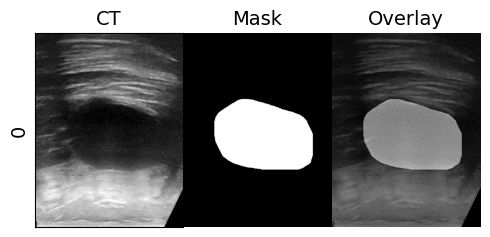

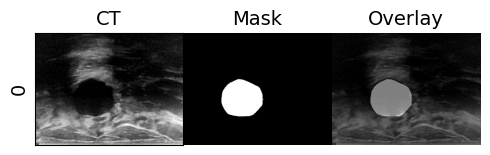

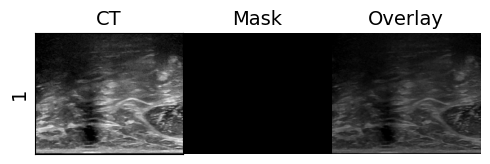

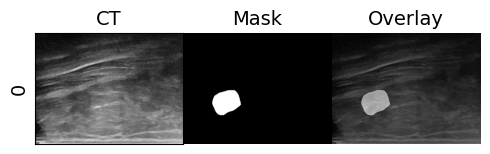

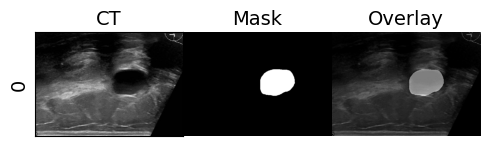

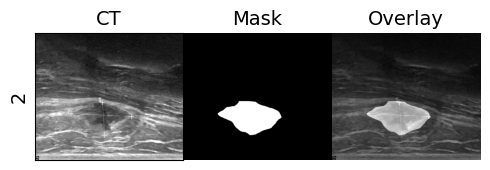

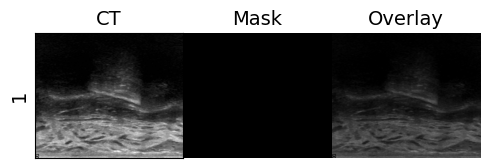

In [ ]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [ ]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path','labels'])

In [ ]:
dataset = dataset[['image_path', 'labels']]

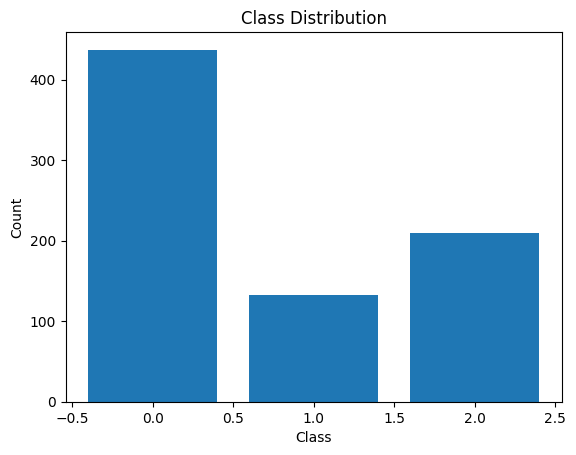

In [ ]:
class_counts = dataset['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
dataset

,image_path,labels
0,/content/breast-ultrasound-images-dataset/Data...,2
1,/content/breast-ultrasound-images-dataset/Data...,2
2,/content/breast-ultrasound-images-dataset/Data...,2
3,/content/breast-ultrasound-images-dataset/Data...,2
4,/content/breast-ultrasound-images-dataset/Data...,2
...,...,...
775,/content/breast-ultrasound-images-dataset/Data...,1
776,/content/breast-ultrasound-images-dataset/Data...,1
777,/content/breast-ultrasound-images-dataset/Data...,1
778,/content/breast-ultrasound-images-dataset/Data...,1


In [ ]:
# Define paths
aug_path = '/content/kaggle/working/augmented_images/'
image_paths = dataset['image_path'].values
labels = dataset['labels'].values

# Create augmented data folder if it doesn't exist
if not os.path.exists(aug_path):
    os.makedirs(aug_path)

# Count the number of samples in each class
label_counts = Counter(labels)

# Calculate the target number of samples for each class (use the maximum count)
target_count = max(label_counts.values())

# Create image augmentation transforms
combined_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

In [ ]:
for i in [1, 2]:
    num_augmentations = label_counts[0] + 220 - label_counts[i]
    image_paths = dataset.loc[dataset['labels'] == i, 'image_path'].values
    while num_augmentations > 0:
        random_index = random.randint(0, len(image_paths) - 1)
        image_path = image_paths[random_index]
        image = Image.open(image_path)
        rotated_image = combined_transform(image.copy())

        rotated_image_np = np.array(rotated_image)
        image_name = os.path.basename(image_path)
        aug_image_path = os.path.join(aug_path, f'{image_name[:-4]}.png')

        cv2.imwrite(aug_image_path, rotated_image_np)
        num_augmentations -= 1

In [ ]:
images = glob.glob("/content/kaggle/working/augmented_images/*.png")
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

new_series = list(zip(images, labels))
dataset_ = pd.DataFrame(new_series, columns=['image_path','labels'])

In [ ]:
concatenated_df = pd.concat([dataset, dataset_], axis=0, ignore_index=True)

In [ ]:
concatenated_df

,image_path,labels
0,/content/breast-ultrasound-images-dataset/Data...,2
1,/content/breast-ultrasound-images-dataset/Data...,2
2,/content/breast-ultrasound-images-dataset/Data...,2
3,/content/breast-ultrasound-images-dataset/Data...,2
4,/content/breast-ultrasound-images-dataset/Data...,2
...,...,...
1090,/content/kaggle/working/augmented_images/norma...,1
1091,/content/kaggle/working/augmented_images/malig...,2
1092,/content/kaggle/working/augmented_images/norma...,1
1093,/content/kaggle/working/augmented_images/norma...,1


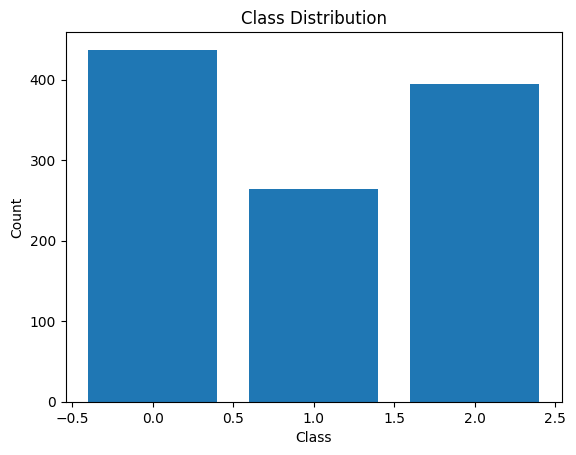

In [ ]:
class_counts = concatenated_df['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
train, test= train_test_split(concatenated_df, test_size=0.3)
test, validation = train_test_split(test, test_size=0.5)

In [ ]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['labels']

        image = Image.open(image_path).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)

        return image, label

In [ ]:
image_size = 256

train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)
val_dataset = CustomImageMaskDataset(validation, val_transforms)

# Create DataLoaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch

    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch

class Trainer:
    def __init__(self, model, optimizer, criterion, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.metrics = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        return epoch_loss, epoch_accuracy

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_accuracy = correct_predictions / len(val_loader.dataset)
        return epoch_loss, epoch_accuracy

    def train(self, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch(train_loader)
            val_loss, val_accuracy = self.evaluate(val_loader)

            print(f'Epoch {epoch + 1}/{num_epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            # Save metrics
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_accuracy'].append(val_accuracy)

    def get_metrics(self):
        return self.metrics


In [ ]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.1MB/s]


In [ ]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 3)
)

for param in model.parameters():
    if param.requires_grad:
        break
    else:
        for param in model.parameters():
            param.requires_grad = False

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
trainer = Trainer(model, optim.Adam(model.parameters(), lr=0.0001), nn.CrossEntropyLoss())
trainer.train(train_dataloader, test_dataloader, num_epochs=50)

metrics = trainer.get_metrics()

Epoch 1/50 => Train Loss: 0.9941, Train Accuracy: 0.5078 | Val Loss: 0.9131, Val Accuracy: 0.5793
Epoch 2/50 => Train Loss: 0.8431, Train Accuracy: 0.5561 | Val Loss: 0.7201, Val Accuracy: 0.6159
Epoch 3/50 => Train Loss: 0.8109, Train Accuracy: 0.5953 | Val Loss: 0.7177, Val Accuracy: 0.5976
Epoch 4/50 => Train Loss: 0.7800, Train Accuracy: 0.6018 | Val Loss: 0.7062, Val Accuracy: 0.7012
Epoch 5/50 => Train Loss: 0.7559, Train Accuracy: 0.6305 | Val Loss: 0.7202, Val Accuracy: 0.5915
Epoch 6/50 => Train Loss: 0.6580, Train Accuracy: 0.6462 | Val Loss: 0.6215, Val Accuracy: 0.7805
Epoch 7/50 => Train Loss: 0.6948, Train Accuracy: 0.7010 | Val Loss: 0.6339, Val Accuracy: 0.6341
Epoch 8/50 => Train Loss: 0.7178, Train Accuracy: 0.6475 | Val Loss: 0.6062, Val Accuracy: 0.8598
Epoch 9/50 => Train Loss: 0.5340, Train Accuracy: 0.7885 | Val Loss: 0.4949, Val Accuracy: 0.8110
Epoch 10/50 => Train Loss: 0.4849, Train Accuracy: 0.7924 | Val Loss: 0.5414, Val Accuracy: 0.8171
Epoch 11/50 => Trai

In [ ]:
# Test on Validation Set
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Val Accuracy: {accuracy * 100:.2f}%')

Val Accuracy: 86.06%


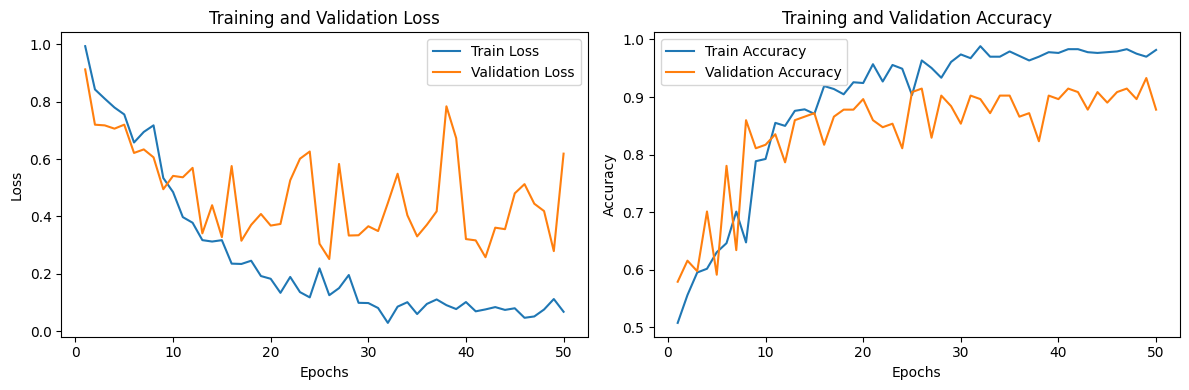

In [ ]:

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_metrics(metrics)